In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns


import statsplot as stp

import anndata

# Simple example

We create first some dummy data for weights for three treatments


In [2]:

N= 8
group_names = ["Control","Treatment 1", "Treatment 2"]

groups = pd.Series( np.repeat(group_names,N), 
index = [ f"Participant_{i+1}" for i in range(N*len(group_names))],
name="Group"
                )
weights = pd.Series(data= np.random.randn(groups.shape[0], 1)[:,0] *5 +15, 
index = groups.index, name="Weight" )
# add difference between groups
weights += groups.map(dict(zip(group_names,[0,0.1,10]))).values


We can plot this data elegantly with seaborn

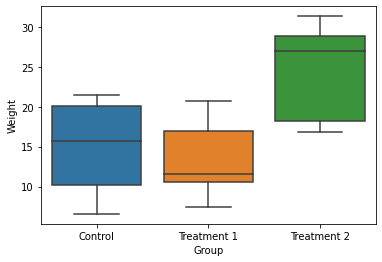

In [3]:
ax  = sns.boxplot(y= weights, x= groups)

If you want to know and plot significance on the plot we can simply use satatsplot with almost the same API

Treatment 1_vs_Control        0.587966
Treatment 2_vs_Control        0.005864
Treatment 2_vs_Treatment 1    0.001300
Name: Weight, dtype: float64

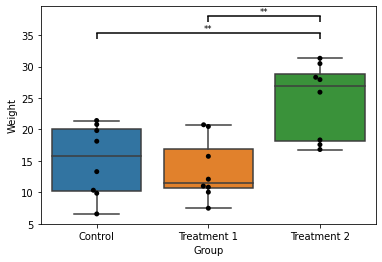

In [4]:

ax, stats= stp.statsplot(variable = weights,test_variable= groups)

stats

If you want to show the value instead of the start you can modify the sig labels.

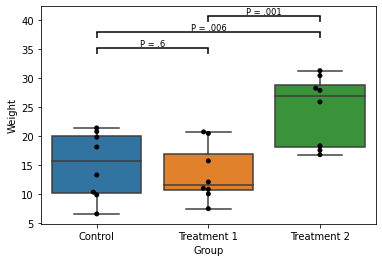

In [5]:
ax, stats= stp.statsplot(variable = weights,test_variable= groups, labelkws= {'show_ns': True, 'use_stars': False})

# Example with nested groups

In [6]:
# create metadata from above groups with before treatment and after treatment time point

df= pd.DataFrame(groups).reset_index().rename(columns={"index":"Participant"})

df_before= df.copy()
df_before["Timepoint"]= "before"
df_before["Measurement"] = np.random.randn(df.shape[0], 1)[:,0] *5 +12

df_after= df.copy()
df_after["Timepoint"]= "after"
df_after["Measurement"] = weights.values

df= pd.concat([df_before,df_after],ignore_index=True)
del df_before, df_after

df.index= "Sample_" + df.index.astype(str)

df.head()


,Participant,Group,Timepoint,Measurement
Sample_0,Participant_1,Control,before,0.591204
Sample_1,Participant_2,Control,before,6.813326
Sample_2,Participant_3,Control,before,12.559294
Sample_3,Participant_4,Control,before,7.547212
Sample_4,Participant_5,Control,before,8.274058


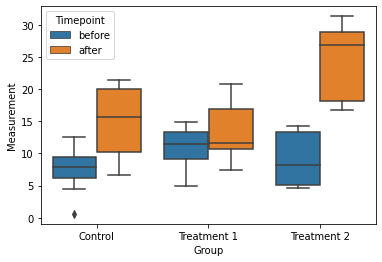

In [7]:
ax = sns.boxplot(data= df, y= "Measurement", hue= "Timepoint", x= "Group", hue_order= ["before","after"])


Control      before_vs_after    0.011874
Treatment 1  before_vs_after    0.328625
Treatment 2  before_vs_after    0.000209
Name: Measurement, dtype: object

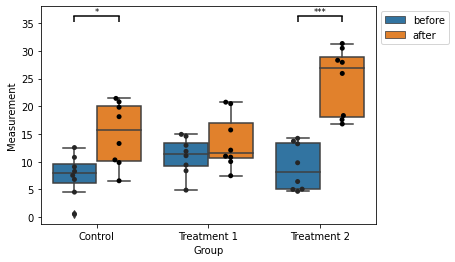

In [8]:
# and here the statsplot version of it.
# see we use paired ttest as we compate the same patients before and after treatment

ax, stats= stp.statsplot(variable = df.Measurement,test_variable= df.Timepoint, grouping_variable= df.Group,
test="ttest_rel",
order_test= ["before","after"]
)
stats

# Example with many variables

Based on microbiome profiling

In [9]:
# Functions to parse taxonomy
import pandas as pd
import numpy as np
import warnings

TAXONMIC_LEVELS = ["Domain", "phylum", "class", "order", "family", "genus", "species"]


def tax2table(Taxonomy_Series, split_character=";", remove_prefix=False):
    """
    Transforms (green_genes) taxonomy to a table
    Expect the following input format:
    d__Bacteria;p__Bacteroidota;c__Bacteroidia;f__
    Replaces empty values and can remove prefix 'c__'
    """

    # drop missing values
    if Taxonomy_Series.isnull().any():
        warnings.warn(
            "Some samples have no taxonomy asigned. Samples:\n"
            + ", ".join(Taxonomy_Series.index[Taxonomy_Series.isnull()].astype(str))
        )

    Tax = Taxonomy_Series.dropna().astype(str).str.split(split_character, expand=True)
    # Add headers as long as we have columns
    Tax.columns = TAXONMIC_LEVELS[: len(Tax.columns)]

    if remove_prefix:
        Tax = Tax.applymap(lambda s: s[3:], na_action="ignore").replace("", np.nan)
    else:
        Tax[Tax.applymap(len, na_action="ignore") == 3] = np.nan

    # add missing values again

    Tax = Tax.reindex(Taxonomy_Series.index)

    return Tax



def load_gtdb_tax(taxonomy_file, remove_prefix=False):

    D = pd.read_table(taxonomy_file, index_col=0)

    Tax = tax2table(D["classification"], remove_prefix=remove_prefix)

    return Tax

In [10]:

# load microbiome data
# The paths here are existing only on my computer

# 1. counts/ relab 
# 2. taxonomy
# 3. metadata

Tax= load_gtdb_tax("../WarmMicrobiota/Metagenome/WD/genomes/taxonomy/gtdbtk.bac120.summary.tsv",remove_prefix=True).sort_index()

# create a label for each genome even if species is not defined 

Tax['Label']= Tax.ffill(axis=1)['species']
Tax.loc[Tax.species.isnull(), 'Label']+=" "+Tax.index[Tax.species.isnull()]


metadata= pd.read_table("../WarmMicrobiota/Metagenome/metadata.tsv", index_col=0)
D= pd.read_table("../WarmMicrobiota/Metagenome/WD/genomes/counts/median_coverage_genomes.tsv",index_col=0)
# relative abundance
relab= (D.T/D.sum(1)).T *100



In [11]:
# But everithing in an anndata object that keeps the data togehter. 

D= anndata.AnnData(relab,obs=metadata,var = Tax)
D

AnnData object with n_obs × n_vars = 32 × 147
    obs: 'Source', 'Group'
    var: 'Domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'Label'

In [12]:
# transform data with centered log transform

from statsplot import transformations

clr_data= transformations.clr(D, log= np.log2)



In [13]:
# create stats table 

ST = stp.StatsTable(clr_data,test_variable= 'Group',grouping_variable="Source", label_variable= 'Label', test='welch',  ref_group="RT")

In [14]:
ST.stats

Pvalue               Statistic            median_diff  \
                Cecum         Feces     Cecum      Feces       Cecum   
            Hot_vs_RT     Hot_vs_RT Hot_vs_RT  Hot_vs_RT   Hot_vs_RT   
user_genome                                                            
MAG001       0.000086  9.776737e-08 -7.182472 -10.031165    3.871136   
MAG002       0.836515  5.090098e-01 -0.210301  -0.680391   -0.065014   
MAG003       0.582933  7.263051e-01 -0.563255  -0.358060    0.018495   
MAG004       0.026453  4.278594e-02  2.575495   2.252542   -1.051217   
MAG005       0.006127  5.384853e-02  3.267759   2.104872   -1.349585   
...               ...           ...       ...        ...         ...   
MAG143       0.011926  1.485765e-02  2.972029   2.840871   -2.133191   
MAG144       0.154094  1.801575e-01  1.595590   1.483567   -0.274401   
MAG145       0.114007  5.550917e-02 -1.685910  -2.101933    0.352819   
MAG146       0.121707  8.657417e-02  1.671672   1.863180   -2.149775   
MAG147       0.684818  3.889707e-01  0.414711   0.898178   -0.281860   

                            pBH            
                Feces     Cecum     Feces  
            Hot_vs_RT Hot_vs_RT Hot_vs_RT  
user_genome                                
MAG001       4.234078  0.001576  0.000014  
MAG002      -0.113145  0.924569  0.699294  
MAG003       0.192079  0.745140  0.847356  
MAG004      -1.638859  0.092516  0.131032  
MAG005      -0.650092  0.032168  0.153959  
...               ...       ...       ...  
MAG143      -2.072522  0.053698  0.065756  
MAG144      -0.178421  0.300687  0.343093  
MAG145       1.037689  0.246455  0.153959  
MAG146      -2.022352  0.259169  0.215702  
MAG147      -0.238357  0.829402  0.589887  

[147 rows x 8 columns]

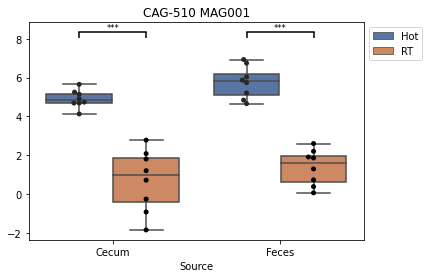

In [15]:

ST.plot('MAG001')